<h1 align="center"> Credit card Fraud Detector </h1>


<h2> Введение </h2>

На данной практие (и еще на парочке занятий потом) мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

<h4> По мотивам кейса, рассмотренного в Зимней школе СберУнивера </h4>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные. </li>
<li> Рассмотреть проблему сильного дисбаланса классов. </li>
<li> Использовать алгоритмы кластеризации </li>
<li> Использовать алгоритмы понижения размерности </li>


## Описание данных и постановка задачи:
**Задача:** Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

**Данные**: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as mpatches
import time
import collections
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# загрузка данных и структура данных
df=pd.read_csv('/content/drive/MyDrive/creditcard.csv')

df.head()

Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Небольшой описательный анализ.

In [5]:
# Основная информация о данных
print("Размер данных:", df.shape)
print("\nТипы данных и количество ненулевых значений:")
print(df.info())

# Статистическое резюме
print("\nСтатистическое резюме данных:")
print(df.describe())

# Анализ классов (баланс классов)
class_counts = df['Class'].value_counts()
non_fraud = class_counts[0]
fraud = class_counts[1]
print(f"\nОбычные транзакции: {non_fraud}")
print(f"Мошеннические транзакции: {fraud}")
print(f"Доля мошеннических транзакций: {fraud / (fraud + non_fraud):.4f}")


Размер данных: (284807, 31)

Типы данных и количество ненулевых значений:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     2848

In [6]:
# проверка наличия пропусков в данных

missing_values = df.isnull().sum()
print("Пропущенные значения в данных:\n", missing_values[missing_values > 0])


Пропущенные значения в данных:
 Series([], dtype: int64)


In [7]:
# названия столбцов

print("Названия столбцов в данных:")
print(df.columns)


Названия столбцов в данных:
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [9]:
# Подсчёт количества транзакций каждого класса
class_counts = df['Class'].value_counts()

# Обычные транзакции (ключ 0) и мошеннические транзакции (ключ 1)
non_fraud_count = class_counts.get(0, 0)  # Получаем количество обычных транзакций (если ключ 0 существует)
fraud_count = class_counts.get(1, 0)  # Получаем количество мошеннических транзакций (если ключ 1 существует)

# Общее количество транзакций
total_transactions = len(df)

# Процентное соотношение
non_fraud_percentage = (non_fraud_count / total_transactions) * 100
fraud_percentage = (fraud_count / total_transactions) * 100

# Вывод на экран
print(f"Обычные транзакции составляют {non_fraud_percentage:.2f}% от всех транзакций")
print(f"Мошеннические транзакции составляют {fraud_percentage:.2f}% от всех транзакций")


Обычные транзакции составляют 99.83% от всех транзакций
Мошеннические транзакции составляют 0.17% от всех транзакций


**Важно!**

Обратите внимание, насколько несбалансированным является наш исходный набор данных! Большинство транзакций не являются мошенническими. Если мы используем этот массив данных в качестве основы для наших моделей прогнозирования и анализа, мы можем получить много ошибок, поскольку наши алгоритмы будут предполагать, что все транзакции не являются мошенничеством. Нам же критически важно сконцентрироваться именно на мошенниках.

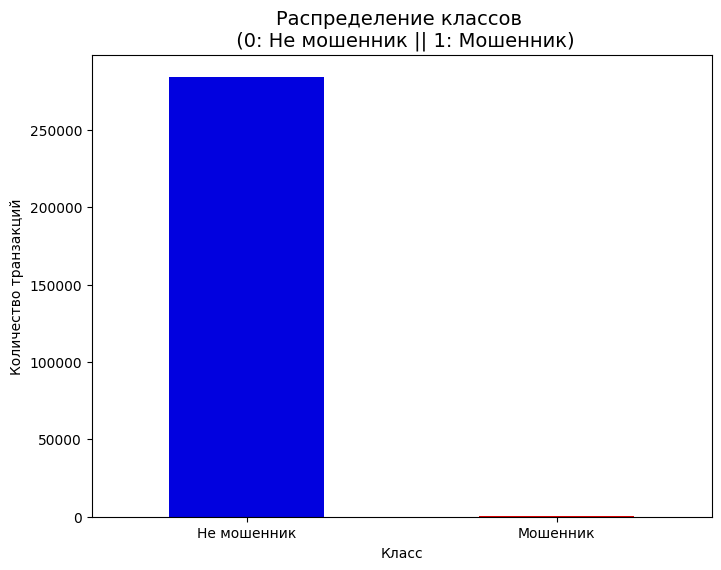

In [11]:
# Импортируем библиотеку для визуализации
import matplotlib.pyplot as plt

# Список цветов для визуализации
colors = ["#0101DF", "#DF0101"]

# Строим гистограмму для столбца 'Class'
plt.figure(figsize=(8, 6))
df['Class'].value_counts().plot(kind='bar', color=colors)

# Добавляем заголовок и подписи
plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
plt.xlabel('Класс')
plt.ylabel('Количество транзакций')

# Показываем гистограмму
plt.xticks([0, 1], ['Не мошенник', 'Мошенник'], rotation=0)
plt.show()


Построим распределения по суммам и времени транзакций.

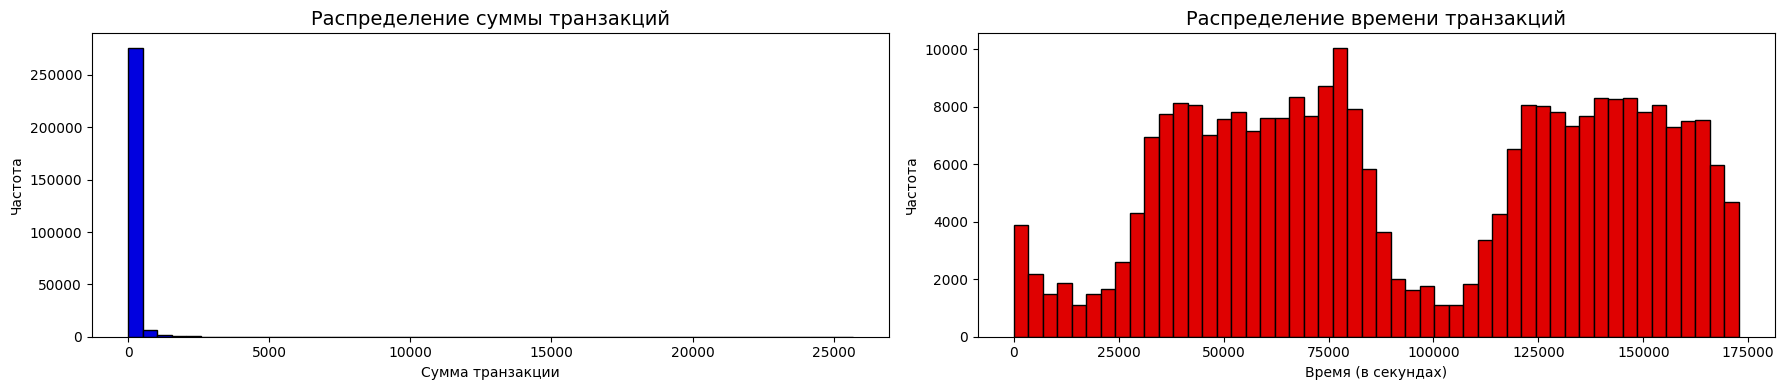

In [12]:
# Импортируем необходимые библиотеки
import matplotlib.pyplot as plt

# Строим графики
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# Для распределения суммы транзакций
amount_val = df['Amount']
ax[0].hist(amount_val, bins=50, color='#0101DF', edgecolor='black')
ax[0].set_title('Распределение суммы транзакций', fontsize=14)
ax[0].set_xlabel('Сумма транзакции')
ax[0].set_ylabel('Частота')

# Для распределения времени транзакций
time_val = df['Time']
ax[1].hist(time_val, bins=50, color='#DF0101', edgecolor='black')
ax[1].set_title('Распределение времени транзакций', fontsize=14)
ax[1].set_xlabel('Время (в секундах)')
ax[1].set_ylabel('Частота')

# Показываем графики
plt.tight_layout()
plt.show()


### Масштабирование
Первым делом нам необходимо отмасштабировать столбцы **Time** и **Amount**. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго **после** разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

### Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:
  - **Переобучение**: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
  - **Неверные корреляции:** Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.

### Разделение данных
**Важно!**

Прежде, чем приступить к балансировке наших данных, мы должны разделить исходный набор данных. Зачем?

Для определения качества работы наших моделей их необходимо тестировать на **исходном** тестовом наборе, а не на тестовом наборе, созданном после балансировки. Цель балансировки заключается в том, чтобы модель смогла найти закономерности для принятия решения по типу транзакции, поэтому мы выравниваем соотношение между мошенническими транзакциями и обычными. Однако проверять качество мы будем именно в "боевых" условиях с учетом реального распределения данных.




In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import numpy as np

# Разделяем данные на признаки и целевую переменную
X = df.drop('Class', axis=1)
y = df['Class']

# Разделяем на обучающую и тестовую выборки
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализируем RobustScaler
rob_scaler = RobustScaler()

# Масштабируем столбцы 'Amount' и 'Time' в обучающем наборе
original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1,1))
original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1,1))

# Масштабируем столбцы 'Amount' и 'Time' в тестовом наборе
original_Xtest['scaled_amount'] = rob_scaler.transform(original_Xtest['Amount'].values.reshape(-1,1))
original_Xtest['scaled_time'] = rob_scaler.transform(original_Xtest['Time'].values.reshape(-1,1))

# Удаляем оригинальные столбцы 'Amount' и 'Time'
original_Xtrain.drop(['Time', 'Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time', 'Amount'], axis=1, inplace=True)

# Преобразуем данные в массивы NumPy
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Распределение классов в обучающем наборе
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)

# Распределение классов в тестовом наборе
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

# Выводим распределение классов
print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label / len(original_ytrain))
print("Тестовый набор:", test_counts_label / len(original_ytest))


Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


## Метод Random Under-Sampling

Применим метод *Random Under-Sampling*, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

#### Алгоритм:
<ul>
<li>Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)  </li>
<li>Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.  </li>
<li> После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем <b>перемешать</b> наши данные для того, чтобы модели не зависили от порядка входных данных.</li>
</ul>

**Важно!**

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [14]:
import pandas as pd

# Перемешиваем данные для предотвращения зависимости от порядка
df = df.sample(frac=1, random_state=42)

# Выделяем мошеннические транзакции (Class == 1)
fraud_df = df.loc[df['Class'] == 1]

# Отбираем 492 случайных немошеннических транзакции (Class == 0)
non_fraud_df = df.loc[df['Class'] == 0][:492]

# Создаем сбалансированный набор данных
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешиваем строки итогового набора данных для исключения порядка
new_df = normal_distributed_df.sample(frac=1, random_state=42)

# Просматриваем первые строки итогового сбалансированного набора данных
new_df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
146884,87941.0,2.054361,-0.122642,-1.245717,0.189567,0.132497,-0.620765,0.059581,-0.148058,0.338940,...,-0.271204,-0.687048,0.271569,-0.497120,-0.270115,0.208619,-0.076075,-0.075428,0.99,0
95597,65385.0,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,-1.016592,...,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1354.25,1
96768,65927.0,0.955253,-0.833374,0.847147,0.725970,-1.322868,-0.238842,-0.565347,0.022443,-0.762247,...,-0.110554,-0.129397,-0.040892,0.364872,0.204756,-0.304578,0.055908,0.062489,156.00,0
75511,56098.0,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,...,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,170.92,1
255556,157284.0,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,-4.128505,...,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,0.77,1


In [16]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/creditcard_full.csv")

In [17]:
new_df.shape

(984, 31)

Распределение классов в подвыборке:
Class
0    492
1    492
Name: count, dtype: int64


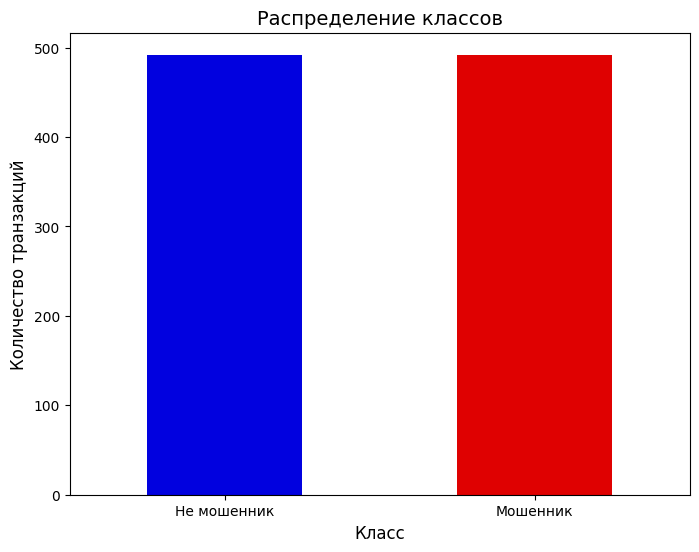

In [18]:
print('Распределение классов в подвыборке:')
print(new_df['Class'].value_counts())

# Проверяем распределение целевой переменной
plt.figure(figsize=(8, 6))
new_df['Class'].value_counts().plot(kind='bar', color=["#0101DF", "#DF0101"])
plt.title('Распределение классов', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Не мошенник', 'Мошенник'], rotation=0)
plt.show()


### Матрица корреляций

Корреляционные матрицы очень важны для понимания данных. Мы хотим узнать, есть ли признаки, которые оказывают сильное влияние на то, является ли конкретная транзакция мошенничеством. Однако важно, чтобы мы использовали сбалансированную подвыборку, чтобы увидеть, какие признаки имеют высокую положительную или отрицательную корреляцию в отношении мошеннических операций.


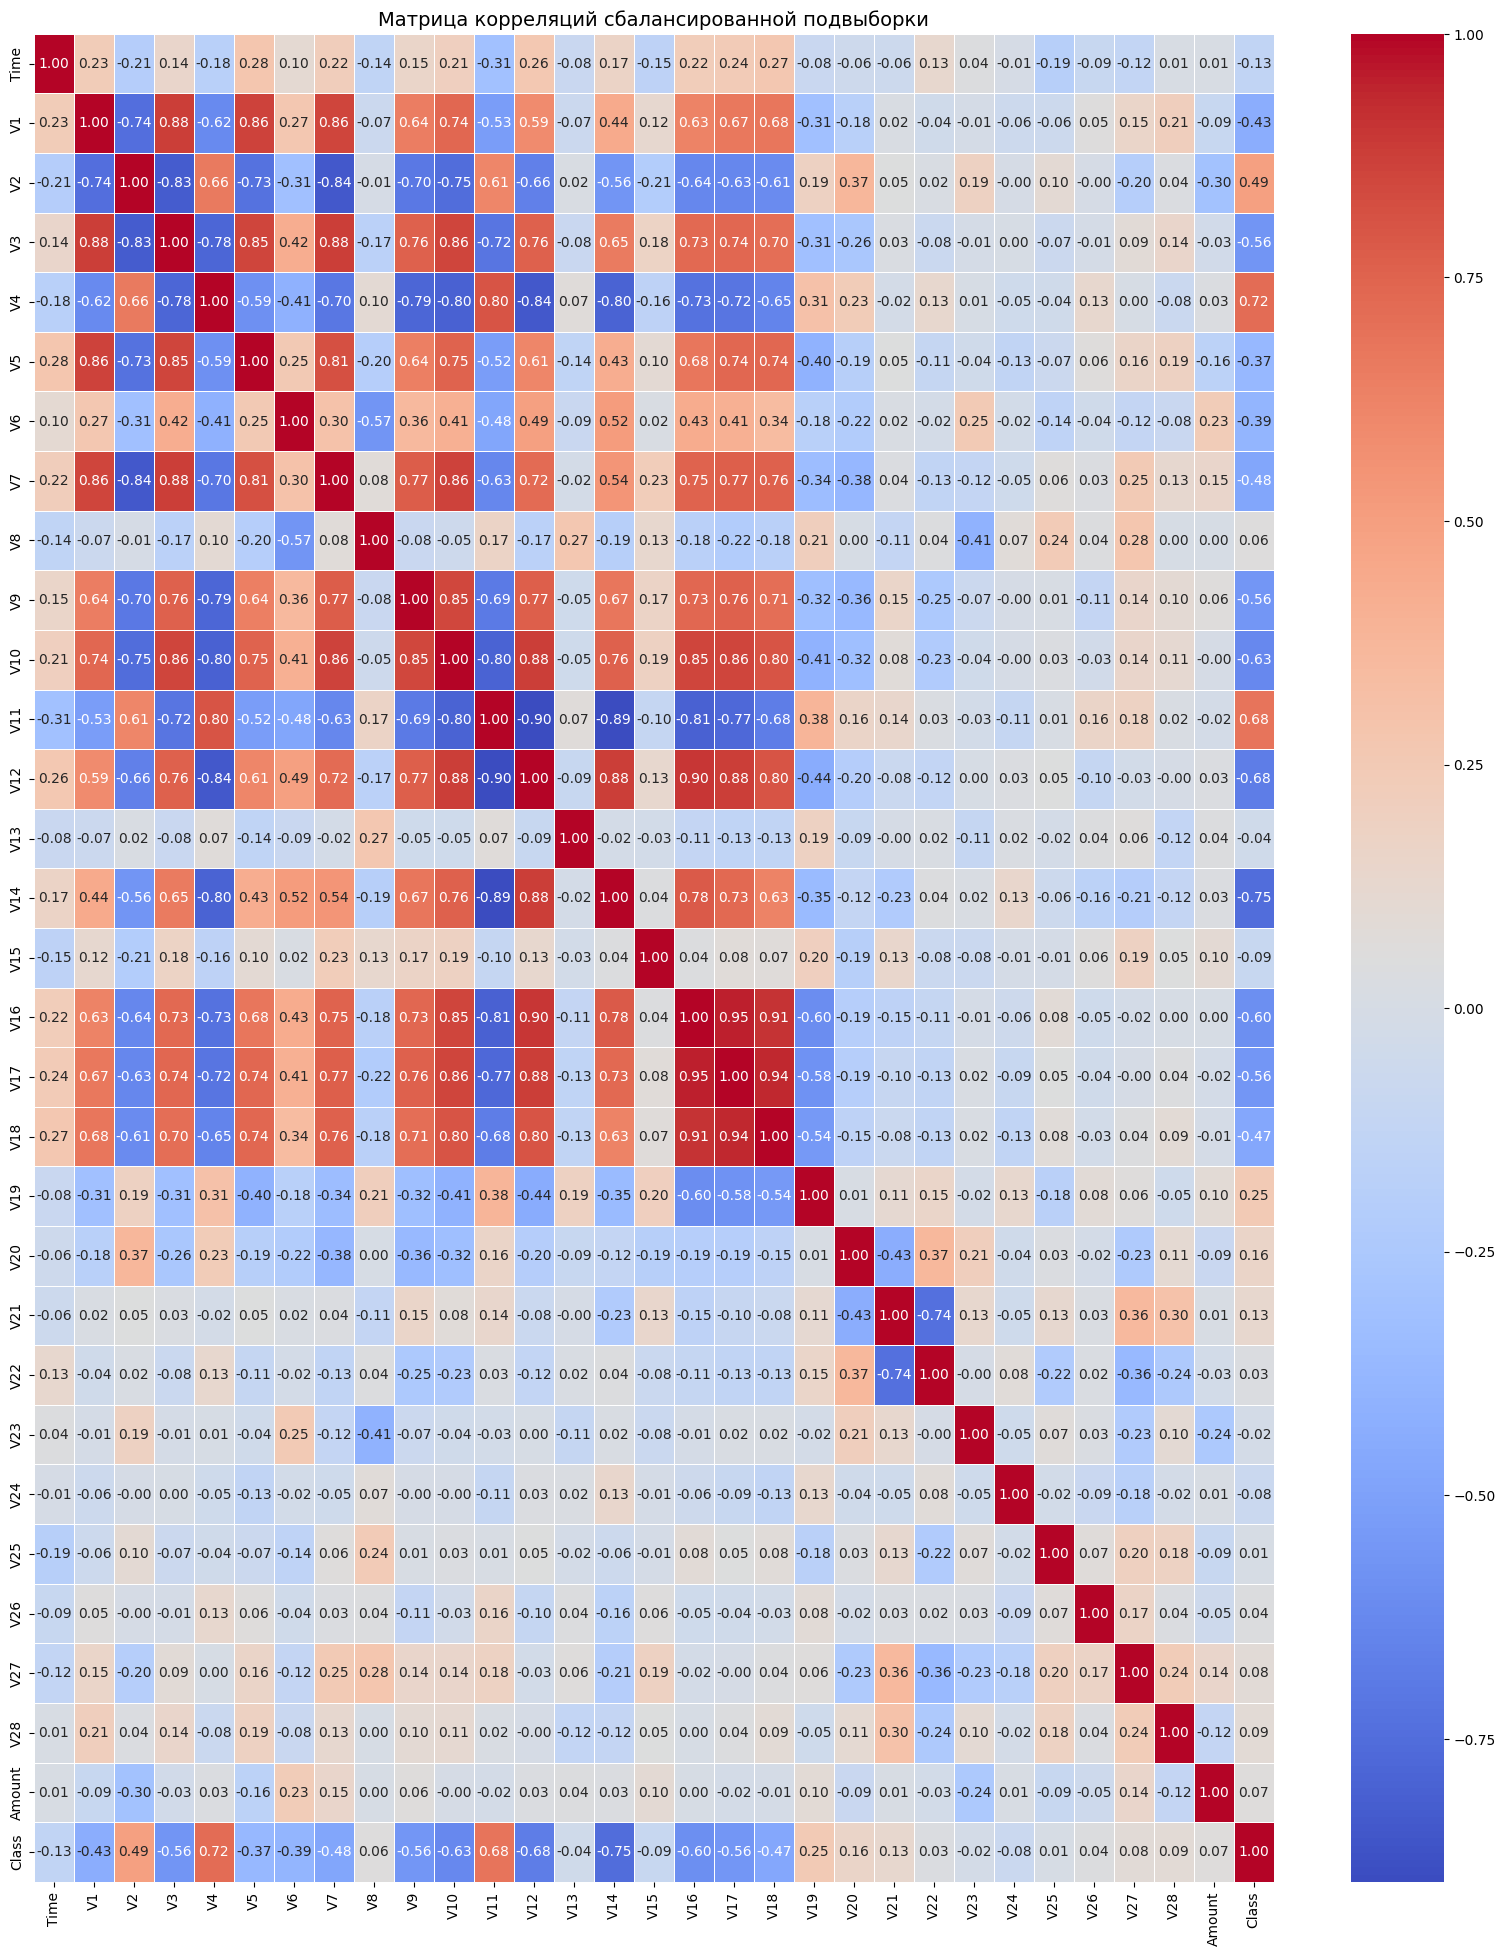

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Вычисляем матрицу корреляций для сбалансированной подвыборки
correlation_matrix = new_df.corr()

# Настроим внешний вид графика
f, ax = plt.subplots(1, 1, figsize=(20, 24))

# Построим тепловую карту матрицы корреляций
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, ax=ax)

# Настроим заголовок графика
ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)

# Покажем график
plt.show()


### Выводы:
<ul>
<li><b>Отрицательные корреляции: </b> Какие признаки  имеют отрицательную корреляцию? Другими словами, чем ниже эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.  </li>
<li> <b> Положительные корреляции: </b> Какие признаки  положительно коррелируют? То есть, чем выше эти значения, тем больше вероятность того, что конечным результатом будет мошенническая операция. </li>
</ul>


**Важно!**

Всегда проверяйте, используете ли вы сбалансированную подвыборку в корреляционной матрице, иначе на корреляционную матрицу повлияет сильный дисбаланс между классами.

Построим теперь Boxplot.

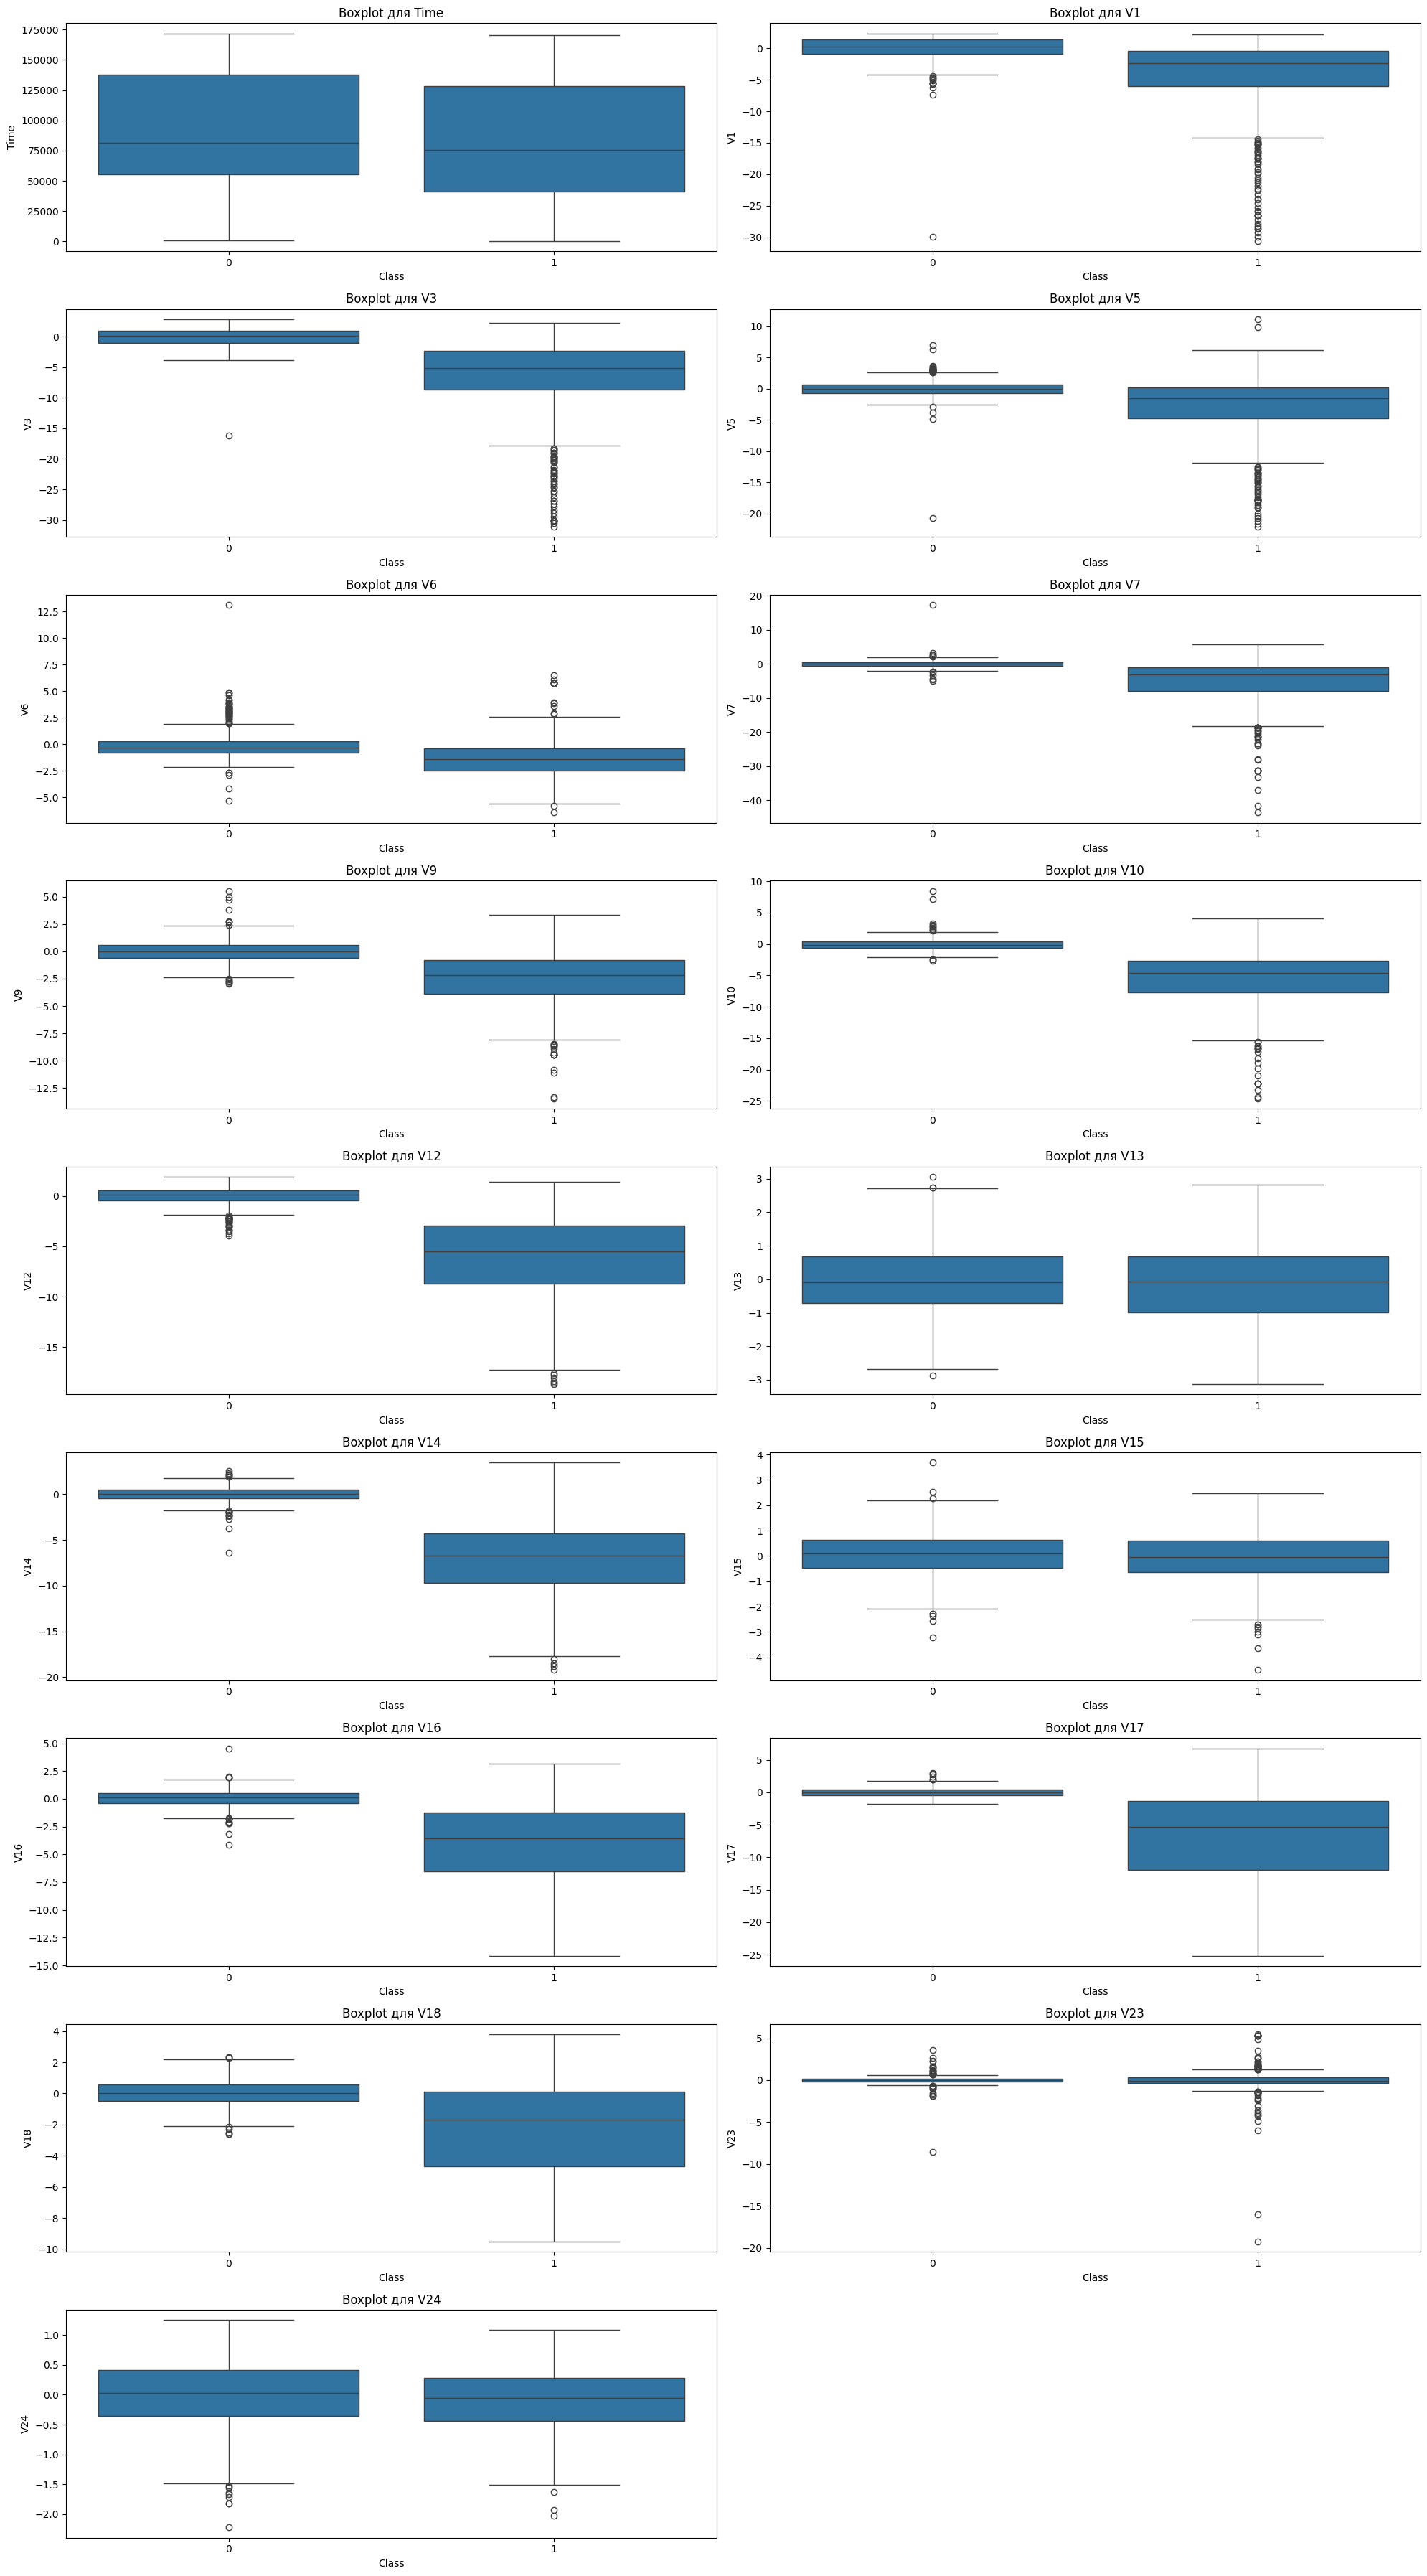

In [24]:
# Отрицательные корреляции

negative_corr_features = correlation_matrix[correlation_matrix['Class'] < 0]['Class'].index.tolist()

# Указываем количество столбцов
ncols = 2
nrows = int(np.ceil(len(negative_corr_features) / ncols))  # Количество строк

# Создаем подграфики для boxplot
f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
axes = axes.flatten()  # Упрощаем индексацию

# Строим boxplot для каждого признака с отрицательной корреляцией
for i, feature in enumerate(negative_corr_features):
    sns.boxplot(x='Class', y=feature, data=new_df, ax=axes[i])
    axes[i].set_title(f'Boxplot для {feature}', fontsize=12)

# Убираем лишние подграфики, если они есть
for j in range(i + 1, len(axes)):
    axes[j].axis('off')  # Скрыть лишние подграфики

plt.tight_layout()
plt.show()

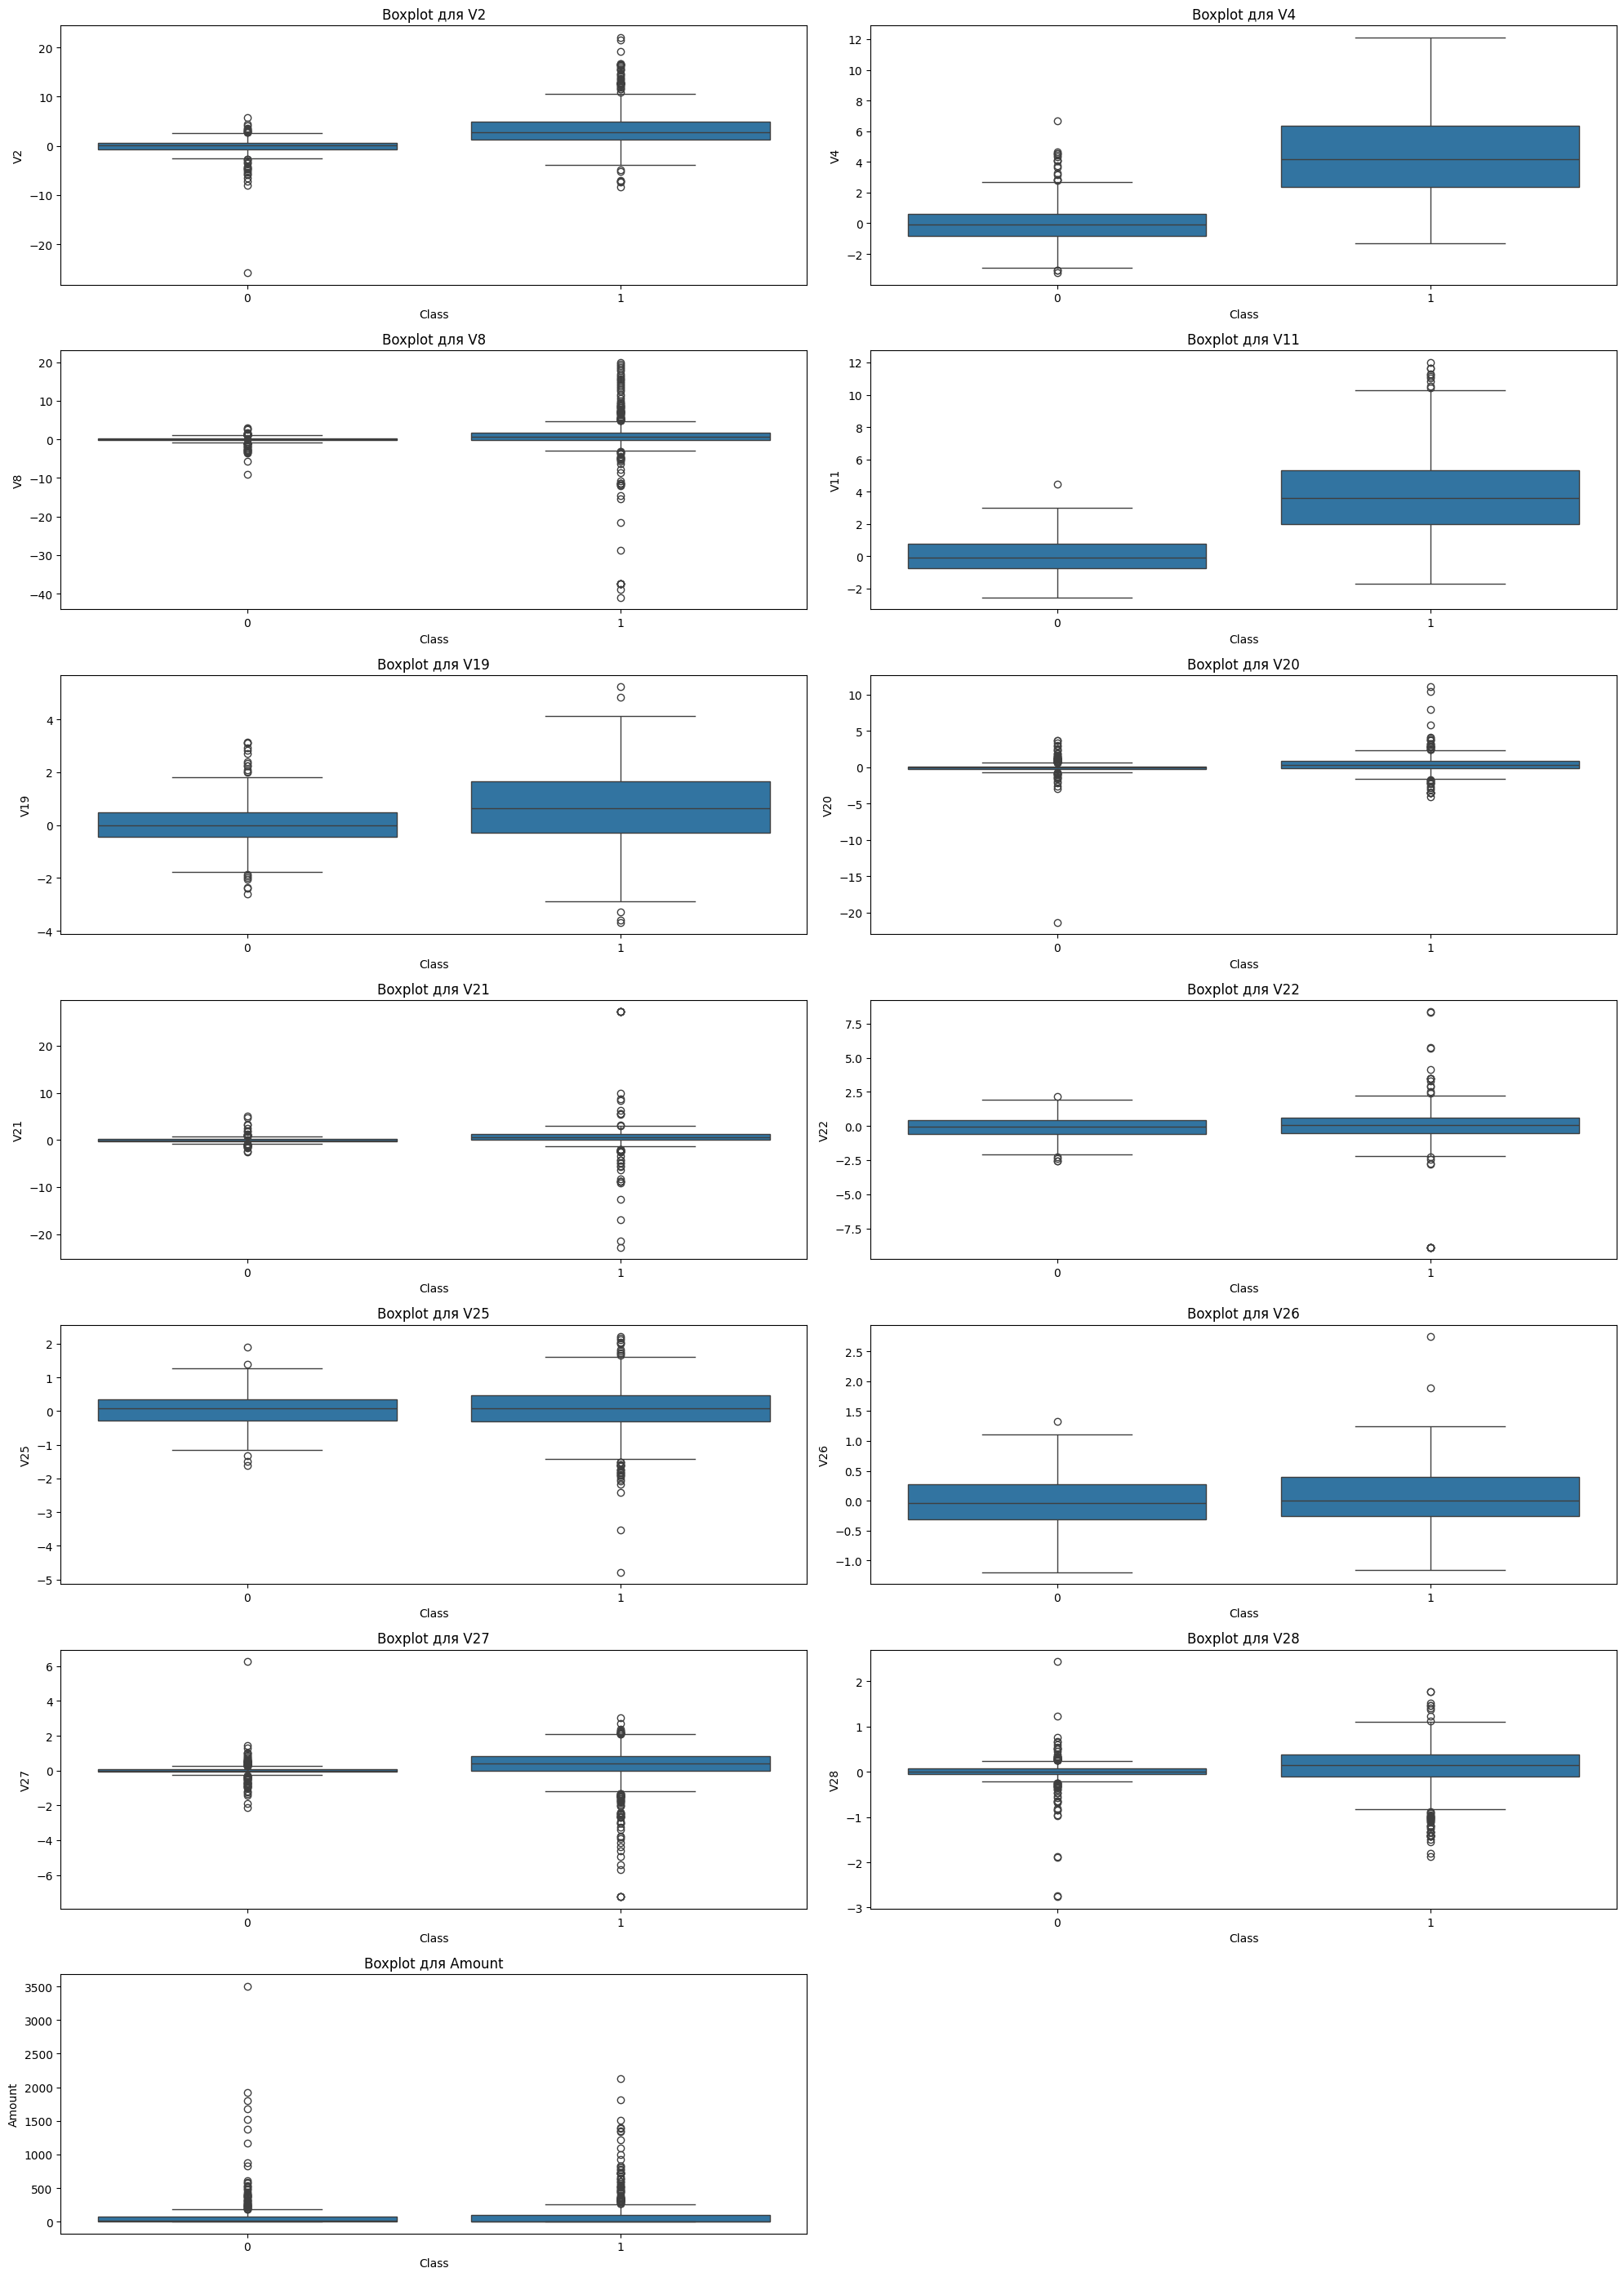

In [25]:
# Положительные корреляции
positive_corr_features = correlation_matrix[correlation_matrix['Class'] > 0]['Class'].index.tolist()
positive_corr_features.remove('Class')  # Удаляем сам класс из списка

ncols = 2
nrows = int(np.ceil(len(positive_corr_features) / ncols))


f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
axes = axes.flatten()


for i, feature in enumerate(positive_corr_features):
    sns.boxplot(x='Class', y=feature, data=new_df, ax=axes[i])
    axes[i].set_title(f'Boxplot для {feature}', fontsize=12)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Какие выводы можно сделать по построенным Boxplot?

Напоминаю.

0 - это не мошеннические транзакции

1 - мошеннические транзакции

## Обработка выбросов

Наша основная цель в этом разделе - удалить выбросы из признаков, которые имеют высокую корреляцию с целевой переменной. Это положительно скажется на точности наших моделей.


### Метод межквартильного размаха:
<ul>
<li> <b>Interquartile Range (IQR): </b> Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.  </li>
<li> <b>Построить Boxplots: </b> С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы. </li>
</ul>

Надо быть внимательным к тому, как далеко мы хотим установить порог для удаления выбросов. Мы определяем порог путем умножения числа (например, 1.5) на интерквартильный размах. Чем выше этот порог, тем меньше выбросов будет обнаружено, а чем ниже этот порог, тем больше выбросов будет обнаружено.  <br><br>

Мы хотим больше сосредоточиться именно на сильных выбросах, а не просто на выбросах. Почему? Потому что удалив все выбросы, мы можем столкнуться с риском потери информации, что приведет к снижению точности наших моделей.


### Итого:
<ul>
<li> <b> Строим распределения </b>  </li>
<li><b>Определяем порог </b> </li>
<li> <b>Удаляем выбросы </b> </li>
<li> <b> Строим Boxplot </b> </li>
</ul>

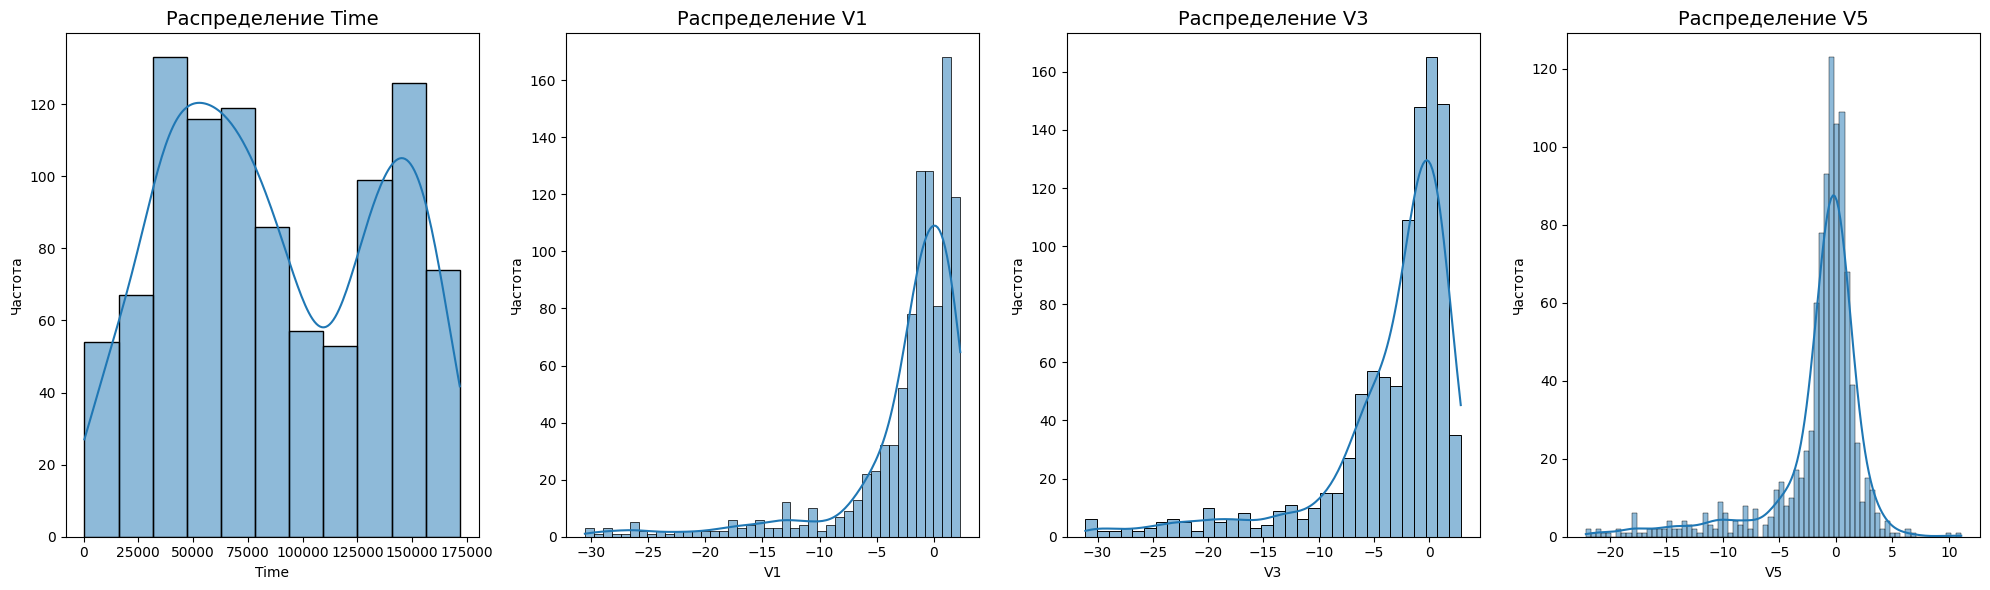

In [28]:
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

# Строим распределения для признаков с отрицательной корреляцией
f, axes = plt.subplots(1, 4, figsize=(20, 6))

# Для каждого признака из первых 4 признаков с отрицательной корреляцией
for i, feature in enumerate(negative_corr_features[:4]):
    sns.histplot(new_df[feature], ax=axes[i], kde=True)  # Строим гистограмму с KDE
    axes[i].set_title(f'Распределение {feature}', fontsize=14)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()


In [29]:
import numpy as np

# Функция для удаления выбросов для заданных признаков
def remove_outliers(df, features, threshold=1.5):
    df_without_outliers = df.copy()

    for feature in features:
        if feature in df.columns:
            # Рассчитываем квартиль 25 и 75 для каждого признака
            q25, q75 = np.percentile(df[feature], 25), np.percentile(df[feature], 75)
            iqr = q75 - q25  # Интерквартильный размах
            cut_off = iqr * threshold  # Порог выбросов
            lower, upper = q25 - cut_off, q75 + cut_off  # Нижняя и верхняя граница для выбросов

            # Фильтруем данные, исключая выбросы
            df_without_outliers = df_without_outliers[(df_without_outliers[feature] >= lower) &
                                                      (df_without_outliers[feature] <= upper)]
            print(f"Для признака {feature}:")
            print(f"Квартиль 25: {q25} | Квартиль 75: {q75}")
            print(f"IQR: {iqr}")
            print(f"Порог: {cut_off}")
            print(f"Нижняя граница: {lower} | Верхняя граница: {upper}")
            print(f"Количество выбросов для {feature}: {len(df) - len(df_without_outliers)}\n")

    return df_without_outliers

# Пример вызова функции для нескольких признаков:
features_to_check = ['V17', 'V14', 'V10']  # Список признаков, для которых нужно удалить выбросы
new_df_without_outliers = remove_outliers(new_df, features_to_check)


Для признака V17:
Квартиль 25: -5.302110958835238 | Квартиль 75: 0.2974074113706817
IQR: 5.599518370205919
Порог: 8.399277555308878
Нижняя граница: -13.701388514144115 | Верхняя граница: 8.696684966679559
Количество выбросов для V17: 77

Для признака V14:
Квартиль 25: -6.721798975234555 | Квартиль 75: 0.1051663899767725
IQR: 6.826965365211327
Порог: 10.24044804781699
Нижняя граница: -16.962247023051546 | Верхняя граница: 10.345614437793763
Количество выбросов для V14: 78

Для признака V10:
Квартиль 25: -4.572042523076584 | Квартиль 75: 0.029811945030273675
IQR: 4.6018544681068585
Порог: 6.902781702160288
Нижняя граница: -11.474824225236873 | Верхняя граница: 6.932593647190562
Количество выбросов для V10: 97



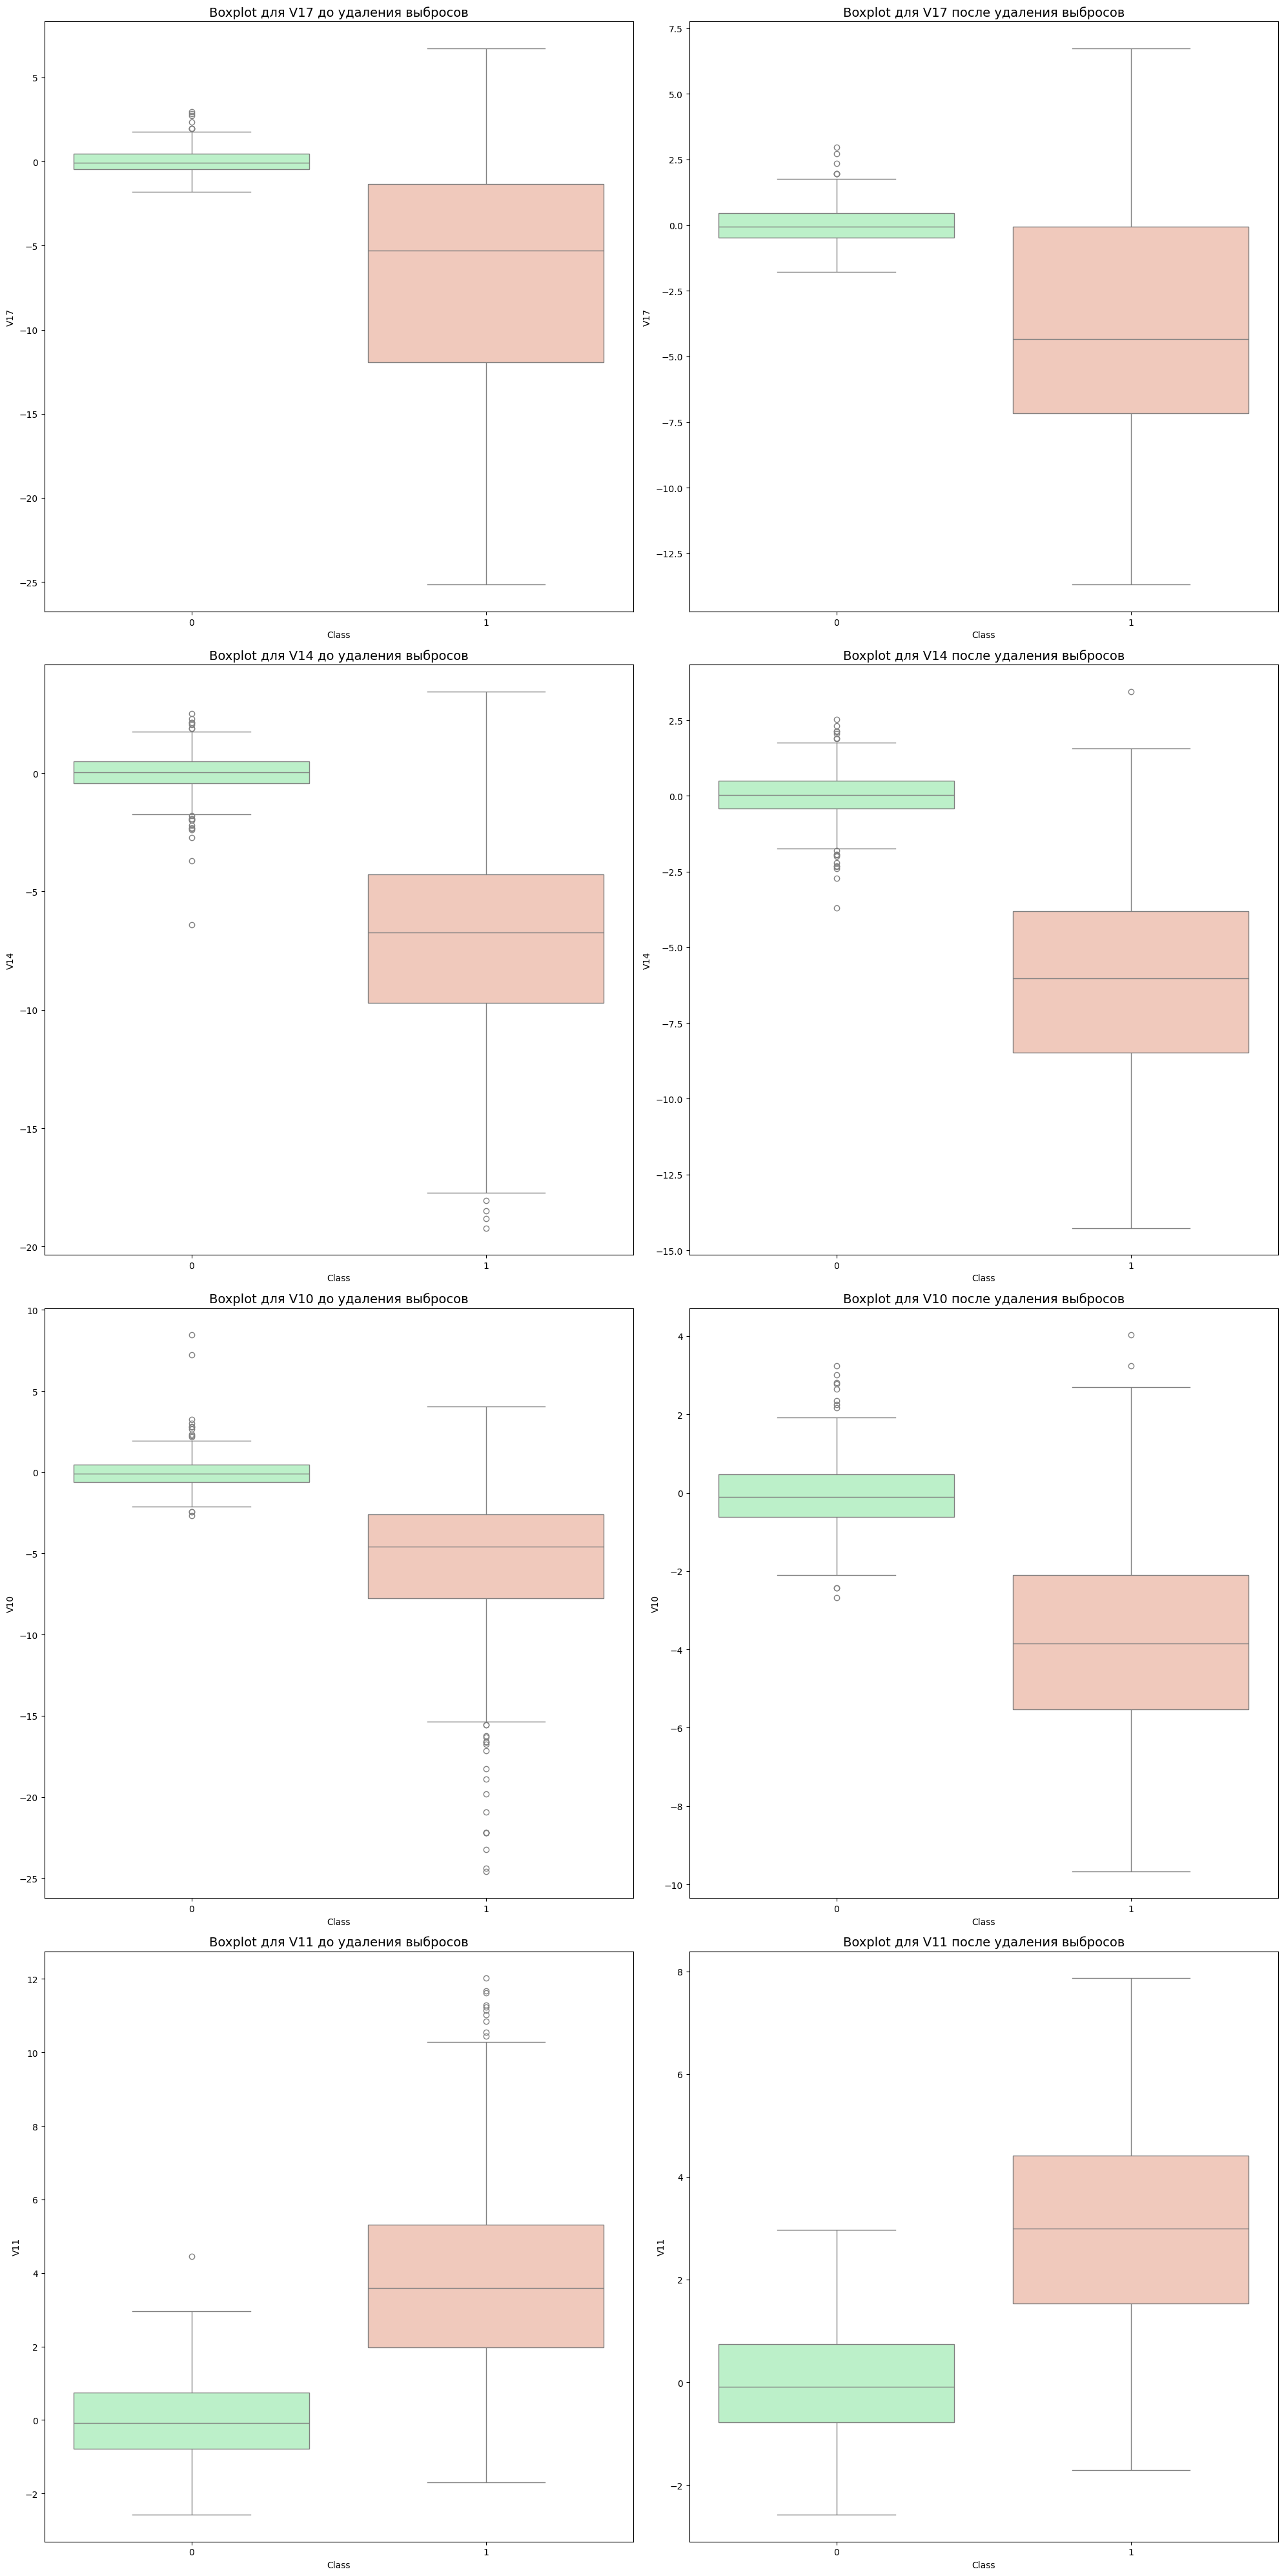

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Подготовим графики
f, ax = plt.subplots(4, 2, figsize=(20, 40))
ax = ax.flatten()  # Упрощаем индексацию

# Цвета для различия до и после удаления выбросов
colors = ['#B3F9C5', '#f9c5b3']

# Boxplot для признака V17
sns.boxplot(x='Class', y='V17', data=new_df, ax=ax[0], palette=colors)
ax[0].set_title('Boxplot для V17 до удаления выбросов', fontsize=14)

sns.boxplot(x='Class', y='V17', data=new_df_without_outliers, ax=ax[1], palette=colors)
ax[1].set_title('Boxplot для V17 после удаления выбросов', fontsize=14)

# Boxplot для признака V14
sns.boxplot(x='Class', y='V14', data=new_df, ax=ax[2], palette=colors)
ax[2].set_title('Boxplot для V14 до удаления выбросов', fontsize=14)

sns.boxplot(x='Class', y='V14', data=new_df_without_outliers, ax=ax[3], palette=colors)
ax[3].set_title('Boxplot для V14 после удаления выбросов', fontsize=14)

# Boxplot для признака V10
sns.boxplot(x='Class', y='V10', data=new_df, ax=ax[4], palette=colors)
ax[4].set_title('Boxplot для V10 до удаления выбросов', fontsize=14)

sns.boxplot(x='Class', y='V10', data=new_df_without_outliers, ax=ax[5], palette=colors)
ax[5].set_title('Boxplot для V10 после удаления выбросов', fontsize=14)

# Для остальных признаков аналогично
# Пример для признака V11
sns.boxplot(x='Class', y='V11', data=new_df, ax=ax[6], palette=colors)
ax[6].set_title('Boxplot для V11 до удаления выбросов', fontsize=14)

sns.boxplot(x='Class', y='V11', data=new_df_without_outliers, ax=ax[7], palette=colors)
ax[7].set_title('Boxplot для V11 после удаления выбросов', fontsize=14)

plt.tight_layout()
plt.show()


In [31]:
# теперь у нас в датафрейме new_df будут лежать данные без выбросов.

new_df = new_df_without_outliers

### Понижение размерности и кластеризация

Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним кластеризацию с помощью трех различных техник кластеризации.



T-SNE заняло 6.4 сек
PCA заняло 0.0033 сек
Truncated SVD заняло 0.0048 сек


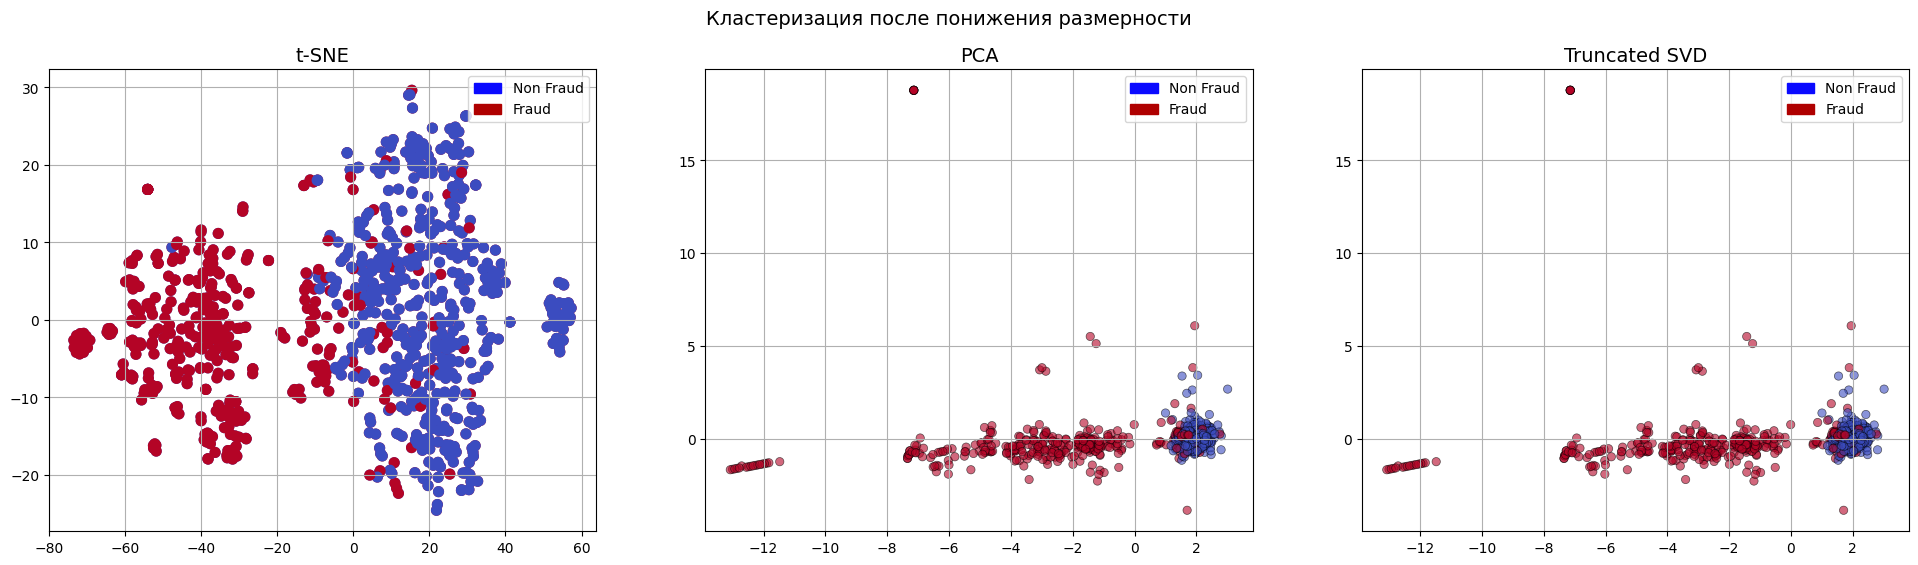

In [38]:
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = new_df.drop('Class', axis=1)  # Удаляем колонку 'Class' для получения признаков
y = new_df['Class']  # 'Class' — целевая переменная

X.drop(['Time','Amount'], axis=1, inplace=True) # Убираем колонки Time и Amount, так как они почти не коррелируют с целевой переменной

X = pd.DataFrame(scaler.fit_transform(X))  # Масштабируем признаки для улучшения работы алгоритмов

# T-SNE алгоритм
t0 = time.time()  # Засекаем время начала работы алгоритма
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)  # Применяем T-SNE для понижения размерности до 2
t1 = time.time()  # Засекаем время окончания
print("T-SNE заняло {:.2} сек".format(t1 - t0))  # Выводим время работы T-SNE

# PCA алгоритм
t0 = time.time()  # Засекаем время начала работы алгоритма
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X)  # Применяем PCA для понижения размерности до 2
t1 = time.time()  # Засекаем время окончания
print("PCA заняло {:.2} сек".format(t1 - t0))  # Выводим время работы PCA

# TruncatedSVD алгоритм
t0 = time.time()  # Засекаем время начала работы алгоритма
X_reduced_svd = TruncatedSVD(n_components=2, random_state=42).fit_transform(X)  # Применяем Truncated SVD для понижения размерности до 2
t1 = time.time()  # Засекаем время окончания
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))  # Выводим время работы Truncated SVD

# Построение графиков
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))  # Создаем подграфики для трех методов
f.suptitle('Кластеризация после понижения размерности', fontsize=14)  # Заголовок для всей фигуры

blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Fraud')  # Создаем легенду для "Non Fraud"
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')  # Создаем легенду для "Fraud"

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)  # Отображаем точки для Non Fraud
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)  # Отображаем точки для Fraud
ax1.set_title('t-SNE', fontsize=14)  # Заголовок для графика t-SNE
ax1.grid(True)  # Включаем сетку
ax1.legend(handles=[blue_patch, red_patch])  # Добавляем легенду на график

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolor='k', linewidth=0.5)  # Отображаем точки для PCA
ax2.set_title('PCA', fontsize=14)  # Заголовок для графика PCA
ax2.grid(True)  # Включаем сетку
ax2.legend(handles=[blue_patch, red_patch])  # Добавляем легенду на график

# Truncated SVD scatter plot
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolor='k', linewidth=0.5)  # Отображаем точки для Truncated SVD
ax3.set_title('Truncated SVD', fontsize=14)  # Заголовок для графика Truncated SVD
ax3.grid(True)  # Включаем сетку
ax3.legend(handles=[blue_patch, red_patch])  # Добавляем легенду на график

plt.show()  # Отображаем все графики


<h3> Выводы: </h3>
<ul>
<li>Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных. </li>
<li> Классы целевой переменной однозначно разделимы, а значит мы можем строить модели! </li>
</ul>

## Продолжение следует .....



<h3 style="text-align: center;">Материалы для изучения scikit-learn:<b></b></h3>

*1) Официальный сайт с подробными описаниями моделей и методов : https://scikit-learn.org/stable/user_guide.html*

*2) Полезный репозиторий с блокнотами: https://github.com/gmonce/scikit-learn-book*

*3) Хороший курс с упражнениями: https://inria.github.io/scikit-learn-mooc/*

In [ ]:
new_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/creditcard_short.csv')